<font size=8>Create Synthetic WOD - TSM sandbox</font>

This notebook subsamples the output of a numerical ocean model using the locations of observations from the World Ocean Database
The xESMF tool is used to subsample the model temperature and salinity fields



In [1]:
import os
import dask
import numpy as np
import pandas as pd
import dask.array as dask
import dask.bag as db
from matplotlib import pyplot as plt
import xarray 
import xesmf 

In [2]:
xarray.set_options(keep_attrs=True) ## This ensures that performing simple operations with xarray (eg converting temperature to Celsius) preserves attributes

## small local cluster

## Big cluster

In [3]:
import os
import dask.config
from dask.distributed import Client,LocalCluster
from dask_jobqueue import PBSCluster
walltime = '02:00:00'
cores = 48
memory = '192GB'
  
cluster = PBSCluster(walltime=str(walltime), cores=cores, memory=str(memory),processes=cores,
                     job_extra=['-q normal','-P xv83','-l ncpus='+str(cores),'-l mem='+str(memory),
                                '-l storage=gdata/xv83+gdata/v14+gdata/ux62+scratch/xv83+gdata/rt52+gdata/ik11+gdata/cj50+gdata/jk72+gdata/hh5'],
                     local_directory='$TMPDIR',
                     header_skip=["select"])
cluster.scale(jobs=2)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/dask_jobqueue/core.py:255: FutureWarning: job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also check config files). If you did not set job_extra_directives yet, job_extra will be respected for now, but it will be removed in a future release. If you already set job_extra_directives, job_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/dask_jobqueue/core.py:293: FutureWarning: header_skip has been renamed to job_directives_skip. You are still using it (even if only set to []; please also check config files). If you did not set job_directives_skip yet, header_skip will be respected for now, but it will be removed in a future release. If you already set job_directives_skip, header_skip is ignored and you can remove it.
  warnings.warn(warn

In [4]:
client = Client(cluster)

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: /proxy/36413/status,
Dashboard: /proxy/36413/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.6.121.56:44249,Workers: 0
Dashboard: /proxy/36413/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [5]:
client

<Client: 'tcp://10.6.121.56:44249' processes=96 threads=96, memory=358.08 GiB>

## Load the model field (here from the 0.1 degree COSIMA model suite)

In [6]:
%%time
# total of 243 output directories
model_data_base_path = '/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_jra55v140_iaf/'

model_subdirs = os.listdir(model_data_base_path)
model_subdirs.sort()

model_temperature_files = []

for i_subdir in model_subdirs:
    #print(i_subdir)
    if os.path.isdir(os.path.join(model_data_base_path,i_subdir)) and "output" in i_subdir:
        model_output_directory = os.path.join(model_data_base_path,i_subdir,'ocean')
        model_output_dir_contents = os.listdir(model_output_directory)
        
        model_output_dir_contents.sort()
        
        for i_file in model_output_dir_contents:
            
            if os.path.isfile(os.path.join(model_output_directory,i_file)) and i_file.startswith("ocean-3d-temp-1-daily-mean"):
                #print(i_file)
                model_temperature_files.append(os.path.join(model_output_directory,i_file))
        
        print(i_subdir)

output000
output001
output002
output003
output004
output005
output006
output007
output008
output009
output010
output011
output012
output013
output014
output015
output016
output017
output018
output019
output020
output021
output022
output023
output024
output025
output026
output027
output028
output029
output030
output031
output032
output033
output034
output035
output036
output037
output038
output039
output040
output041
output042
output043
output044
output045
output046
output047
output048
output049
output050
output051
output052
output053
output054
output055
output056
output057
output058
output059
output060
output061
output062
output063
output064
output065
output066
output067
output068
output069
output070
output071
output072
output073
output074
output075
output076
output077
output078
output079
output080
output081
output082
output083
output084
output085
output086
output087
output088
output089
output090
output091
output092
output093
output094
output095
output096
output097
output098
output099


In [7]:
model_temperature_files

['/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_jra55v140_iaf/output116/ocean/ocean-3d-temp-1-daily-mean-ym_1987_01.nc',
 '/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_jra55v140_iaf/output116/ocean/ocean-3d-temp-1-daily-mean-ym_1987_02.nc',
 '/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_jra55v140_iaf/output116/ocean/ocean-3d-temp-1-daily-mean-ym_1987_03.nc',
 '/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_jra55v140_iaf/output117/ocean/ocean-3d-temp-1-daily-mean-ym_1987_04.nc',
 '/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_jra55v140_iaf/output117/ocean/ocean-3d-temp-1-daily-mean-ym_1987_05.nc',
 '/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_jra55v140_iaf/output117/ocean/ocean-3d-temp-1-daily-mean-ym_1987_06.nc',
 '/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_jra55v140_iaf/output118/ocean/ocean-3d-temp-1-daily-mean-ym_1987_07.nc',
 '/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_jra55v140_iaf/output118/ocean/oce

In [18]:
%%time
model_temperature_dataset = xarray.open_mfdataset(model_temperature_files,parallel=True)

CPU times: user 3.34 s, sys: 205 ms, total: 3.54 s
Wall time: 3.6 s


In [19]:
model_temperature_dataset

<xarray.Dataset>
Dimensions:         (xt_ocean: 3600, yt_ocean: 2700, st_ocean: 75,
                     st_edges_ocean: 76, time: 11688, nv: 2)
Coordinates:
  * xt_ocean        (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.85 79.95
  * yt_ocean        (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.94 89.98
  * st_ocean        (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * st_edges_ocean  (st_edges_ocean) float64 0.0 1.083 ... 5.61e+03 5.809e+03
  * time            (time) datetime64[ns] 1987-01-01T12:00:00 ... 2018-12-31T...
  * nv              (nv) float64 1.0 2.0
Data variables:
    temp            (time, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(31, 75, 2700, 3600), meta=np.ndarray>
    average_T1      (time) datetime64[ns] dask.array<chunksize=(31,), meta=np.ndarray>
    average_T2      (time) datetime64[ns] dask.array<chunksize=(31,), meta=np.ndarray>
    average_DT      (time) timedelta64[ns] dask.array<chunksize=(31,), meta=np.ndarray>
    time_bounds     (time, nv) timedelta64[ns] dask.array<chunksize=(31, 2), meta=np.ndarray>
Attributes:
    filename:   ocean-3d-temp-1-daily-mean-ym_1987_01.nc
    title:      ACCESS-OM2-01
    grid_type:  mosaic
    grid_tile:  1
    history:    20200704T1458Z: /g/data/ik11/inputs/access-om2/bin/mppnccombi...

# 34TB!

In [20]:
model_temperature_dataset.nbytes/1e9

34082.208612648

In [21]:
grid010 = xarray.open_dataset('/g/data/ik11/grids/ocean_grid_01.nc')
grid010 = grid010.rename({'grid_x_C': 'xu_ocean', 'grid_y_C': 'yu_ocean',
                          'grid_x_T': 'xt_ocean', 'grid_y_T': 'yt_ocean'})

In [22]:
grid010

<xarray.Dataset>
Dimensions:     (zt: 75, zb: 75, yt_ocean: 2700, xt_ocean: 3600,
                 yu_ocean: 2700, xu_ocean: 3600)
Coordinates:
  * zt          (zt) float32 0.5413 1.681 2.94 ... 5.313e+03 5.511e+03 5.709e+03
  * zb          (zb) float32 1.083 2.279 3.601 ... 5.412e+03 5.61e+03 5.809e+03
Dimensions without coordinates: yt_ocean, xt_ocean, yu_ocean, xu_ocean
Data variables:
    geolon_t    (yt_ocean, xt_ocean) float64 ...
    geolon_c    (yu_ocean, xu_ocean) float64 ...
    geolat_t    (yt_ocean, xt_ocean) float64 ...
    geolat_c    (yu_ocean, xu_ocean) float64 ...
    depth_t     (yt_ocean, xt_ocean) float64 ...
    num_levels  (yt_ocean, xt_ocean) float64 ...
Attributes:
    history:  Fri Mar 20 16:34:09 2020: ncrename -v x_T,geolon_t -v x_C,geolo...
    NCO:      netCDF Operators version 4.9.2 (Homepage = http://nco.sf.net, C...

In [23]:
model_temperature_dataset = model_temperature_dataset.assign_coords({'geolat_t': grid010.geolat_t, 'geolon_t': grid010.geolon_t})
model_temperature_dataset = model_temperature_dataset.rename({'xt_ocean': 'x', 'yt_ocean': 'y',
                                                              'geolon_t': 'longitude', 'geolat_t': 'latitude'})


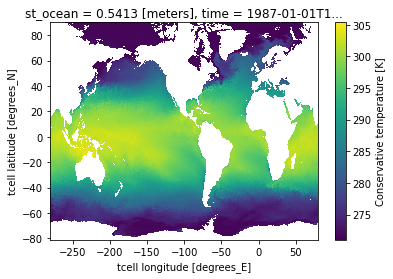

In [24]:
model_temperature_dataset['temp'][0,0,:,:].plot()

In [ ]:
#lon_name = 'xt_ocean'
#model_temperature_dataset = model_temperature_dataset.assign_coords({lon_name: (model_temperature_dataset[lon_name] + 360)  % 360})
#model_temperature_dataset.sortby(model_temperature_dataset)
#ds_out = ds_out.assign_coords({'lon': ds_out.lon - 100.})
#model_temperature_dataset = model_temperature_dataset.assign_coords({lon_name: (model_temperature_dataset[lon_name] + (90+280)) % 360})
#model_temperature_dataset = model_temperature_dataset.assign_coords({lon_name: (model_temperature_dataset[lon_name] - 100)})

# I believe for xESMF to not bog down *ALL* space must be in one chunk?

In [25]:
model_temperature_dataset = model_temperature_dataset.chunk({'time':1,'st_ocean':-1,'x':-1,'y':-1})

In [26]:
model_temperature_dataset

<xarray.Dataset>
Dimensions:         (x: 3600, y: 2700, st_ocean: 75, st_edges_ocean: 76,
                     time: 11688, nv: 2)
Coordinates:
  * x               (x) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * y               (y) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
  * st_ocean        (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * st_edges_ocean  (st_edges_ocean) float64 0.0 1.083 ... 5.61e+03 5.809e+03
  * time            (time) datetime64[ns] 1987-01-01T12:00:00 ... 2018-12-31T...
  * nv              (nv) float64 1.0 2.0
    latitude        (y, x) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    longitude       (y, x) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
Data variables:
    temp            (time, st_ocean, y, x) float32 dask.array<chunksize=(1, 75, 2700, 3600), meta=np.ndarray>
    average_T1      (time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
    average_T2      (time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
    average_DT      (time) timedelta64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
    time_bounds     (time, nv) timedelta64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
Attributes:
    filename:   ocean-3d-temp-1-daily-mean-ym_1987_01.nc
    title:      ACCESS-OM2-01
    grid_type:  mosaic
    grid_tile:  1
    history:    20200704T1458Z: /g/data/ik11/inputs/access-om2/bin/mppnccombi...

# Load the World Ocean Database data


In [27]:
WOD_base_file_path ='/g/data/ul08/WOD_2018'

year = 2018
WOD_file_name_stem = 'wod_'


obs_platform_type = ['ctd','xbt','pfl','mrb','gld','drb','osd']

WOD_object = dict(zip(obs_platform_type, [None]*len(obs_platform_type)))


for i_platform_type in obs_platform_type:
    
    WOD_object[i_platform_type] = xarray.open_dataset(os.path.join(WOD_base_file_path,str(2018),
                                                                   WOD_file_name_stem + i_platform_type + '_' + str(year) + '.nc') )
    


FileNotFoundError: [Errno 2] No such file or directory: b'/g/data/ul08/WOD_2018/2018/wod_ctd_2018.nc'

In [ ]:
platform_type = 'xbt'

WOD_lat = WOD_object[platform_type]['lat'].copy().values
WOD_lon = WOD_object[platform_type]['lon'].copy().values


In [ ]:
WOD_lon[WOD_lon>90] = WOD_lon[WOD_lon>90] - (270+90) 

In [ ]:
plt.scatter(WOD_object[platform_type]['lon'],WOD_object[platform_type]['lat'],s=25)
plt.scatter(WOD_lon,WOD_lat,s=10)


In [ ]:
ds_WOD_stations = xarray.Dataset()
ds_WOD_stations['longitude'] = xarray.DataArray(data=WOD_lon, dims=('casts'))
ds_WOD_stations['latitude'] = xarray.DataArray(data=WOD_lat, dims=('casts'))
ds_WOD_stations['time'] = xarray.DataArray(data=WOD_object[platform_type]['time'].values, dims=('casts'))

ds_WOD_stations = ds_WOD_stations.where(np.logical_and(ds_WOD_stations['longitude']>-280,
                                                       ds_WOD_stations['longitude']<-180),drop=True)
ds_WOD_stations = ds_WOD_stations.where(np.logical_and(ds_WOD_stations['latitude']>-50,
                                                       ds_WOD_stations['latitude']<0),drop=True)


In [ ]:
plt.contourf(model_temperature_dataset['temp']['xt_ocean'],model_temperature_dataset['temp']['yt_ocean'],
             model_temperature_dataset['temp'][0,0,:,:],25)
plt.scatter(ds_WOD_stations['longitude'],ds_WOD_stations['latitude'])

#plt.scatter(WOD_lon,WOD_lat,s=10)


In [ ]:
WOD_object['pfl']['z'].max()

In [ ]:
#model_temperature = model_temperature.drop({'x', 'y'}).cf.to_dataset()


#model_temperature = model_temperature.sel(time=ds_WOD_stations['time'].values,method='nearest')

#model_temperature = model_temperature.chunk({'time':5,'st_ocean':-1,'y':-1,'x':-1})

In [ ]:
max_depth = 800

n_levels = model_temperature_dataset['st_ocean'].sel(st_ocean=slice(0,max_depth)).size
n_casts  = ds_WOD_stations['casts'].size
KELVIN_TO_CELSIUS = -273.15



WOD_temperature_synthetic = xarray.DataArray(np.zeros([n_casts,n_levels],dtype=np.float32),
                                             dims=['casts','depth'],
                                             coords={'casts':ds_WOD_stations['casts'],
                                                     'depth':model_temperature_dataset['st_ocean'][0:n_levels].values}).to_dataset(name='temp')
WOD_temperature_synthetic['latitude'] = ds_WOD_stations['latitude']


WOD_temperature_synthetic['longitude'] = ds_WOD_stations['longitude']
WOD_temperature_synthetic['time'] = ds_WOD_stations['time']



#model_temperature_level = model_temperature_dataset['temp'].sel(st_ocean=slice(0,max_depth)) 


for i_level in range(25,n_levels):
    model_temperature_level = model_temperature_dataset['temp'].isel(st_ocean=i_level).load() 
    model_temperature_level = model_temperature_level + KELVIN_TO_CELSIUS
    
    
    regridder = xesmf.Regridder(model_temperature_level, ds_WOD_stations, 'bilinear', locstream_out=True) #,reuse_weights=True)
    
    WOD_temperature_synthetic_level = regridder(model_temperature_level)
    WOD_temperature_synthetic_level.to_netcdf(os.path.join('/g/data4/ul08/CARS_v2/Synthetic_WOD/staging', 
                                                           'WOD_synthetic_' + platform_type + '_2018_' + 'level_' + str(i_level) +  '.nc') ) 
    
    
    WOD_temperature_synthetic['temp'][:,i_level] = WOD_temperature_synthetic_level.sel(time=ds_WOD_stations['time'],method='nearest')
    
    


In [ ]:
WOD_temperature_synthetic_level

In [ ]:


for i_level in range(0,n_levels):
    #Get the slice for the current synthetic layer
    WOD_temperature_synthetic_level = xarray.open_dataset(os.path.join('/g/data4/ul08/CARS_v2/Synthetic_WOD/staging', 
                                                           'WOD_synthetic_' + platform_type + '_2018_' + 'level_' + str(i_level) +  '.nc') )
    WOD_temperature_synthetic['temp'][:,i_level] = WOD_temperature_synthetic_level['__xarray_dataarray_variable__'].sel(time=ds_WOD_stations['time'],method='nearest')
    WOD_temperature_synthetic_level.close()

In [ ]:
WOD_temperature_synthetic['temp'][20,:].plot()

In [ ]:
model_temperature_level

In [ ]:
model_temperature_level

In [ ]:
plt.scatter(WOD_temperature_synthetic['longitude'],WOD_temperature_synthetic['latitude'],c=WOD_temperature_synthetic['temp'][:,0],vmin=10,vmax=35)
plt.colorbar()

In [ ]:
model_temperature_level[0,:,:].plot(vmin=10,vmax=35)

In [ ]:
model_temperature_level

In [ ]:
regridder.to_netcdf('/g/data4/ul08/CARS_v2/regrid_weights_xbt.nc')

In [ ]:
test_xbt.compute()

In [ ]:
unique_days = np.unique(ds_WOD_stations['time.dayofyear'])

In [ ]:
for i_day in unique_days:
    
    model_temperature_dayofyear = model_temperature.sel(time=model_temperature['time'].dt.dayofyear.isin([i_day]))
    WOD_time_index = ds_WOD_stations['time'].dt.dayofyear.isin([i_day])
    ds_WOD_stations_dayofyear = ds_WOD_stations.where(WOD_time_index,drop=True)
    

    dsa
    

In [ ]:
WOD_time_index

In [ ]:
ds_WOD_stations_dayofyear

In [ ]:
ds_WOD_stations

In [ ]:
regridder = xesmf.Regridder(model_temperature, ds_WOD_stations, 'bilinear', locstream_out=True)


In [ ]:
regridder

In [ ]:
WOD_temperature_synthetic = regridder(model_temperature).compute()



In [ ]:
WOD_temperature_synthetic

In [ ]:
model_temperature

In [ ]:
WOD_temperature_synthetic['temp'][0,:,0].plot()

In [28]:
client.shutdown()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/dask_jobqueue/core.py:255: FutureWarning: job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also check config files). If you did not set job_extra_directives yet, job_extra will be respected for now, but it will be removed in a future release. If you already set job_extra_directives, job_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/dask_jobqueue/core.py:293: FutureWarning: header_skip has been renamed to job_directives_skip. You are still using it (even if only set to []; please also check config files). If you did not set job_directives_skip yet, header_skip will be respected for now, but it will be removed in a future release. If you already set job_directives_skip, header_skip is ignored and you can remove it.
  warnings.warn(warn